In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import mglearn as mg
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline , make_pipeline
from sklearn.preprocessing import OneHotEncoder , StandardScaler , LabelEncoder , OrdinalEncoder  
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier , KNeighborsRegressor
from sklearn.model_selection import train_test_split , KFold , cross_val_score , GridSearchCV
from sklearn.linear_model import Lasso , LogisticRegression
from sklearn.metrics import mean_squared_error
import seaborn as sb
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
import scipy.stats as stats

0- reading the data

In [2]:
aisles = pd.read_csv(r"archive\aisles.csv")
department = pd.read_csv(r"archive\departments.csv")
pro_prior = pd.read_csv(r"archive\order_products__prior.csv")
pro_train = pd.read_csv(r"archive/order_products__train.csv")
orders = pd.read_csv(r"archive\orders.csv")
products = pd.read_csv(r"archive\products.csv")

1- Joins and memory optimization

In [3]:
def reduce_memory(df):

    for col in df.columns:
        col_type = df[col].dtype

        if "int" in str(col_type):
            df[col] = df[col].astype("int32")

        elif "float" in str(col_type):
            df[col] = df[col].astype("float32")

        #بالبدايه حطيت بس else بعدين اكتشفت انه في انواع بيانات ثانيه مثل bool
        elif col_type == "object":
            df[col] = df[col].astype("category")

    return df

In [4]:

dfs = [aisles , department , pro_prior , pro_train , orders , products]

for i in range(len(dfs)):
    dfs[i] = reduce_memory(dfs[i])

In [5]:
#   في m1 
#   pro_prior بلشنا ب هذول لانه يحتوي تفاصيل المنتجات داخل الطلبات
#   orders هو اللي بحتوي على معلومات الطلب , المستخدم , الوقت
m1 = pd.merge(pro_prior , orders , on = "order_id" , how = "left")
m2 = pd.merge(m1 , products , on = "product_id" , how = "left")
m3 = pd.merge(m2 , department , on = "department_id" , how = "left")
Full_DataSet = pd.merge(m3 , aisles , on = "aisle_id" , how = "left")

In [6]:
print(Full_DataSet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 15 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int32   
 1   product_id              int32   
 2   add_to_cart_order       int32   
 3   reordered               int32   
 4   user_id                 int32   
 5   eval_set                category
 6   order_number            int32   
 7   order_dow               int32   
 8   order_hour_of_day       int32   
 9   days_since_prior_order  float32 
 10  product_name            category
 11  aisle_id                int32   
 12  department_id           int32   
 13  department              category
 14  aisle                   category
dtypes: category(4), float32(1), int32(10)
memory usage: 1.6 GB
None


In [7]:
#كنت بدي اصير اعمل قراءه للملف مره ثانيه عشان ما اضل اعمل دمج كل ما اشغل الكود , بس اكتشفت انه تحميله بقعد وقت اكثر
#Full_DataSet.to_csv('archive/full_instacart_data.csv', index=False)

3+4+5: cleaning , preprocessing and scaling


In [ ]:
del aisles["aisle"]
del department["department"]
 
print(Full_DataSet.isnull().sum())
print("---------------------------------------")

#كان هدفي اشوف ال نان من هون بس ما زبطت ف شفتها من الملف نفسه
Full_DataSet.head(10)
#اللي بين معي انه ال نان بكون موجود لكل اول اوردير بطلبه المستخدم\الزبون

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
product_name                    0
aisle_id                        0
department_id                   0
department                      0
aisle                           0
dtype: int64
---------------------------------------


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,dairy eggs,eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,produce,fresh vegetables
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,pantry,spices seasonings
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,pantry,oils vinegars
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,pantry,baking ingredients
5,2,17794,6,1,202279,prior,3,5,9,8.0,Carrots,83,4,produce,fresh vegetables
6,2,40141,7,1,202279,prior,3,5,9,8.0,Original Unflavored Gelatine Mix,105,13,pantry,doughs gelatins bake mixes
7,2,1819,8,1,202279,prior,3,5,9,8.0,All Natural No Stir Creamy Almond Butter,88,13,pantry,spreads
8,2,43668,9,0,202279,prior,3,5,9,8.0,Classic Blend Cole Slaw,123,4,produce,packaged vegetables fruits
9,3,33754,1,1,205970,prior,16,5,17,12.0,Total 2% with Strawberry Lowfat Greek Strained...,120,16,dairy eggs,yogurt


In [9]:
def check_outliers(FD , col):
    print(f"{col}: min:{FD[col].min()} , max:{FD[col].max()} , mean:{FD[col].mean()} , median:{FD[col].median()}")


In [10]:
def show_outliers(Full_DataSet):
    col = "add_to_cart_order"
    x = Full_DataSet[col].dropna()

    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outliers = x[(x < lower) | (x > upper)]
    print(f"n={len(x)}  outliers={len(outliers)}  IQR-range=[{lower:.1f}, {upper:.1f}]")

    plt.figure(figsize=(12, 4))
    sns.histplot(x, bins=50, kde=True, color="#FFA07A")
    plt.title("Histogram + KDE of add_to_cart_order")
    plt.xlabel("add_to_cart_order")
    plt.tight_layout()
    plt.show()

order_hour_of_day: min:0 , max:23 , mean:13.424977405995204 , median:13.0


days_since_prior_order: min:0.0 , max:30.0 , mean:11.10406494140625 , median:8.0


add_to_cart_order: min:1 , max:145 , mean:8.351075517175559 , median:6.0


add_to_cart_order
1      3214874
2      3058126
3      2871133
4      2664106
5      2442025
        ...   
141          1
142          1
143          1
144          1
145          1
Name: count, Length: 145, dtype: int64

n=32434489  outliers=1357124  IQR-range=[-9.0, 23.0]


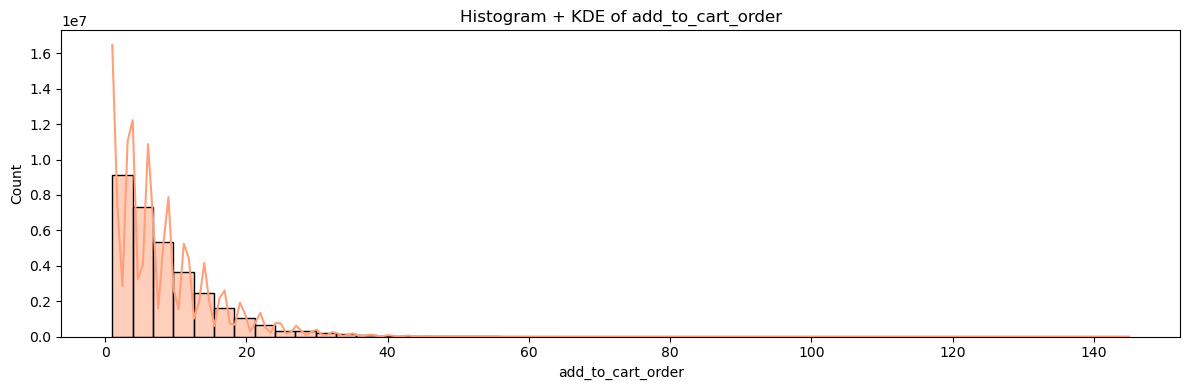

In [ ]:
#DF = pd.DataFrame(Full_DataSet)

colname = ["order_hour_of_day" , "days_since_prior_order" , "add_to_cart_order"]
for col in colname:
    check_outliers(Full_DataSet , col)
    print("\n")


print(Full_DataSet["add_to_cart_order"].value_counts().sort_index())
print()

show_outliers(Full_DataSet)

count    3.243449e+07
mean     8.324914e+00
std      6.975978e+00
min      1.000000e+00
25%      3.000000e+00
50%      6.000000e+00
75%      1.100000e+01
max      4.000000e+01
Name: add_to_cart_order, dtype: float64

n=32434489  outliers=1357124  IQR-range=[-9.0, 23.0]


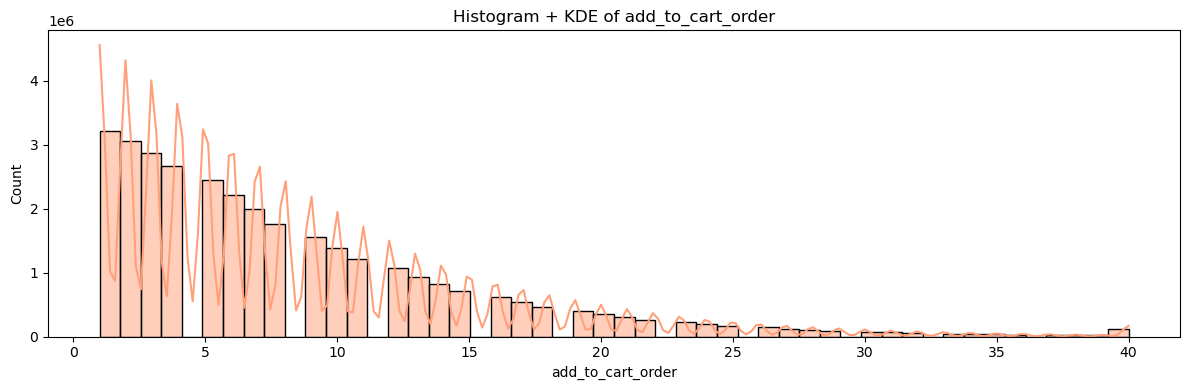

In [ ]:
#من القيم اللي حسبتها بالاضافه للرسم , بين معي انه بعد ال40 بتصير عندي نبسة التكرارات قليله مقارنة بالباقي ف اخترتها تكون حد فاصل 
Full_DataSet["add_to_cart_order"] =  np.where(Full_DataSet["add_to_cart_order"] > 40 , 40 , Full_DataSet["add_to_cart_order"])
print(Full_DataSet["add_to_cart_order"].describe())
print()

show_outliers(Full_DataSet)

In [13]:
Full_DataSet.dtypes

order_id                     int32
product_id                   int32
add_to_cart_order            int32
reordered                    int32
user_id                      int32
eval_set                  category
order_number                 int32
order_dow                    int32
order_hour_of_day            int32
days_since_prior_order     float32
product_name              category
aisle_id                     int32
department_id                int32
department                category
aisle                     category
dtype: object

In [14]:
imputer = SimpleImputer(strategy = "constant" , fill_value = 0)

Full_DataSet["days_since_prior_order"] = imputer.fit_transform(Full_DataSet["days_since_prior_order"].values.reshape(-1,1))

DF = pd.DataFrame(Full_DataSet , columns = Full_DataSet.columns)

#DF.to_csv('archive/full_instacart_data.csv', index=False)
DF.head()



,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,dairy eggs,eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,produce,fresh vegetables
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,pantry,spices seasonings
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,pantry,oils vinegars
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,pantry,baking ingredients


In [ ]:
def best_params_for_TE(DF , high_cols):
    unique_users = DF['user_id'].unique()
    selected_users = np.random.choice(unique_users, size=3000, replace=False)
    #رفعت عدد العينات ل 5000 والكود طول لتنه اشتغل ف عشان هيك قللتهم ك حل وسط

    df_check = DF[DF['user_id'].isin(selected_users)].copy()

    df_check[high_cols] = df_check[high_cols].astype(str)

    xc = df_check.drop("reordered", axis=1)
    yc = df_check['reordered']

    pipeline = make_pipeline(
        ce.TargetEncoder(cols=high_cols) , 
        RandomForestClassifier(
            n_estimators = 100,  # عدد الأشجار
            max_depth = 10 ,      # عمق الشجرة (عشان ما ياخذ وقت طويل)
            random_state = 42 ,
            n_jobs = -1          # تشغيل كل المعالجات
        )
    )

    param_grid = {
        'targetencoder__smoothing': [1, 10, 50] ,
        'targetencoder__min_samples_leaf': [1, 20]
    }

    grid_search = GridSearchCV(
        estimator = pipeline ,
        param_grid = param_grid ,
        cv = 3 ,                 
        scoring = 'roc_auc' ,
        n_jobs = -1 ,
        verbose = 1
    )

    print("\n")
    grid_search.fit(xc, yc)

    print("\n" + "=" * 30)
    print(f"Best ROC_AUC: {grid_search.best_score_:.4f}")
    print("Best Parameters:")
    print(grid_search.best_params_)

    #تجربه فاشله لتحديد افضل المعاملات
    '''
    smoothing_op = [1, 2, 10, 20, 50, 100]
    leaf_op = [1, 5, 10, 20, 50]
    Kfold_op = [3, 5, 10] 

    results = []

    print("-" * 50)

    for k in Kfold_op:
        current_kf = KFold(n_splits=k, shuffle=True, random_state=42)
        
        for sm in smoothing_op:
            for leaf in leaf_op:
                
                encoder = ce.TargetEncoder(
                    cols=high_cols, 
                    min_samples_leaf=leaf, 
                    smoothing=sm
                )
                
                model = LogisticRegression(solver='liblinear')
                
                pipeline = make_pipeline(encoder, model)
                
                try:
                    scores = cross_val_score(pipeline, xc, yc, cv=current_kf, scoring="roc_auc")
                    mean_auc = scores.mean()
                    std_auc = scores.std()
                    
                    results.append({
                        'n_splits': k,
                        'smoothing': sm,
                        'min_samples_leaf': leaf,
                        'auc_mean': mean_auc,
                        'auc_std': std_auc
                    })
                    
                    print(f"K={k}, Smooth={sm}, Leaf={leaf} -> AUC: {mean_auc:.4f}")
                    
                except Exception as e:
                    print(f"Error at K={k}, Smooth={sm}, Leaf={leaf}: {e}")

    results_df = pd.DataFrame(results)

    sorted_results = results_df.sort_values(by='auc_mean', ascending=False)

    print("\n")
    print("TOP 3 PARAMETER COMBINATIONS:")
    print(sorted_results.head(3))
    print()

    if not sorted_results.empty:
        best_params = sorted_results.iloc[0]
        print(f"\nthe best:\nSmoothing: {best_params['smoothing']}\nMin Samples Leaf: {best_params['min_samples_leaf']}\nK-Fold Splits: {int(best_params['n_splits'])}")
    '''

In [ ]:
def which_scaler(num_cols):

    SAMPLE_SIZE = 500000 

    if len(DF) > SAMPLE_SIZE:

        df_sampled = DF.sample(n=SAMPLE_SIZE, random_state=42).copy()
    else:
        df_sampled = DF.copy()

    fig, axes = plt.subplots(len(num_cols), 2, figsize=(14, 4 * len(num_cols)))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    for i, col in enumerate(num_cols):
        
        sns.histplot(
            df_sampled[col], 
            kde=True, 
            ax=axes[i, 0], 
            color='skyblue', 
            edgecolor='black',
            line_kws={'linewidth': 3}
        )
        axes[i, 0].set_title(f'Distribution of {col}', fontsize=12)
        axes[i, 0].set_xlabel(col, fontsize=10)
        axes[i, 0].grid(axis='y', linestyle='--', alpha=0.7)

        stats.probplot(
            df_sampled[col].dropna(), 
            dist="norm", 
            plot=axes[i, 1]
        )
        axes[i, 1].set_title(f'Q-Q Plot of {col}', fontsize=12)
        axes[i, 1].set_xlabel('Theoretical Quantiles (Normal)', fontsize=10)
        axes[i, 1].set_ylabel('Sample Quantiles', fontsize=10)

    plt.savefig('numerical_features_distribution_analysis.png', bbox_inches='tight')
    print("تم حفظ تحليل التوزيعات في 'numerical_features_distribution_analysis.png'")
    plt.show()



In [17]:
num_cols = ["order_hour_of_day", "days_since_prior_order", "add_to_cart_order", "order_number"]
low_cols = ["department_id", "order_dow"] 
high_cols = ["user_id", "product_id", "aisle_id"] 
target_col = "reordered"
Frequency_col = "product_name"

#الرسم ببينلك انه التةويع مبعثر وغير طبيعي وبحتوي على اوتلايرز كثيييييررر ,  عشان هيك كان افضل خيار استخدام 
#SD لانه افضل بالتعامل مع الاوتلايرز وما بتأثر فيهم بشكل واضح وسلبي

#which_scaler(num_cols)

In [18]:
#بعد اكثر من تجربه افضل ناتج طلعلي كن زي اللي حطيتهم بالبريبروسيس
#best_params_for_TE(DF , high_cols) 

In [19]:
num_cols = ["order_hour_of_day", "days_since_prior_order", "add_to_cart_order", "order_number"]
low_cols = ["department_id", "order_dow"] 
high_cols = ["user_id", "product_id", "aisle_id"] 
target_col = "reordered"
Frequency_col = "product_name"

KF = KFold(n_splits = 7 , shuffle = True , random_state = 42)

preprocessor = ColumnTransformer(
    transformers=[
        ("encoding" , OneHotEncoder(handle_unknown = "ignore" , sparse_output = False , drop = "first") , low_cols) ,
        ("target_encoding" , ce.TargetEncoder(min_samples_leaf = 20 , smoothing = 50) , high_cols) ,
        ("Frequency" , ce.CountEncoder(normalize = True)) ,
        ("scaling" , StandardScaler() , num_cols)
                 ]
)
# معامل الفريكوانسي ترو ليش؟ , لانه اذا حطيتو فولز اللي رح يصير انه رح يوخذ عدد التكرارات زي ما هو في هيك بصير عندي تباين كبير ورح يصير بحاجه لسكيلينق 
#اما هيك اللي رح يعملو انه رح يحولهم لنسبة بين ال 0 وال 1

